In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
#default_exp callback.mixup

In [ ]:
#export
from fastai.basics import *
from torch.distributions.beta import Beta

In [ ]:
#hide
from nbdev.showdoc import *
from fastai.test_utils import *

# MixUp and Friends

> Callbacks that can apply the MixUp (and variants) data augmentation to your training

In [ ]:
from fastai.vision.all import *

In [ ]:
#export
def reduce_loss(loss, reduction='mean'):
    "Reduce the loss based on `reduction`"
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss

In [ ]:
#export
class MixHandler(Callback):
    "A handler class for implementing `MixUp` style scheduling"
    run_valid = False
    def __init__(self, alpha=0.5): 
        self.distrib = Beta(tensor(alpha), tensor(alpha))
        
    def before_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf
            
    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

Most `Mix` variants will perform the data augmentation on the batch, so to implement your `Mix` you should adjust the `before_batch` event with however your training regiment requires. Also if a different loss function is needed, you should adjust the `lf` as well. 

##  MixUp -

In [ ]:
#export
class MixUp(MixHandler):
    "Implementation of https://arxiv.org/abs/1710.09412"
    def __init__(self, alpha=.4): super().__init__(alpha)
    def before_batch(self):
        lam = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))
        
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

First we'll look at a very minimalistic example to show how our data is being generated with the `PETS` dataset:

In [ ]:
path = untar_data(URLs.PETS)
pat        = r'([^/]+)_\d+.*$'
fnames     = get_image_files(path/'images')
item_tfms  = [Resize(256, method='crop')]
batch_tfms = [*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]
dls = ImageDataLoaders.from_name_re(path, fnames, pat, bs=64, item_tfms=item_tfms, 
                                    batch_tfms=batch_tfms)

We can examine the results of our `Callback` by grabbing our data during `fit` at `before_batch` like so:

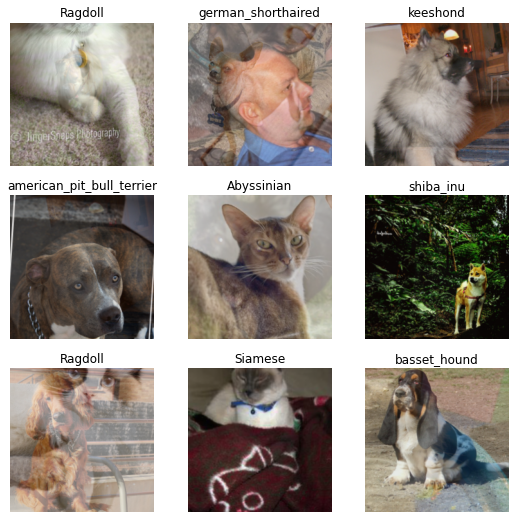

In [ ]:
mixup = MixUp(1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

In [ ]:
#hide
test_ne(b[0], mixup.x)
test_eq(b[1], mixup.y)

We can see that every so often an image gets "mixed" with another. 

How do we train? You can pass the `Callback` either to `Learner` directly or to `cbs` in your fit function:

In [ ]:
#slow
learn = cnn_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[error_rate])
learn.fit_one_cycle(1, cbs=mixup)

epoch,train_loss,valid_loss,error_rate,time
0,2.041960,0.495492,0.162382,00:12


## CutMix -

In [ ]:
#export
class CutMix(MixHandler):
    "Implementation of `https://arxiv.org/abs/1905.04899`"
    def __init__(self, alpha=1.): super().__init__(alpha)
    def before_batch(self):
        bs, _, H, W = self.x.size()
        self.lam = self.distrib.sample((1,))
        shuffle = torch.randperm(bs)
        xb1,self.yb1 = self.x[shuffle], tuple((self.y[shuffle],))
        x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam)
        self.learn.xb[0][..., y1:y2, x1:x2] = xb1[..., y1:y2, x1:x2]
        self.lam = (1 - ((x2-x1)*(y2-y1))/float(W*H)).item()
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))
            
    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_w = torch.round(W * cut_rat).type(torch.long)
        cut_h = torch.round(H * cut_rat).type(torch.long)
        # uniform
        cx = torch.randint(0, W, (1,))
        cy = torch.randint(0, H, (1,))
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        return x1, y1, x2, y2

Similar to `MixUp`, `CutMix` will cut a random box out of two images and swap them together. We can look at a few examples below:

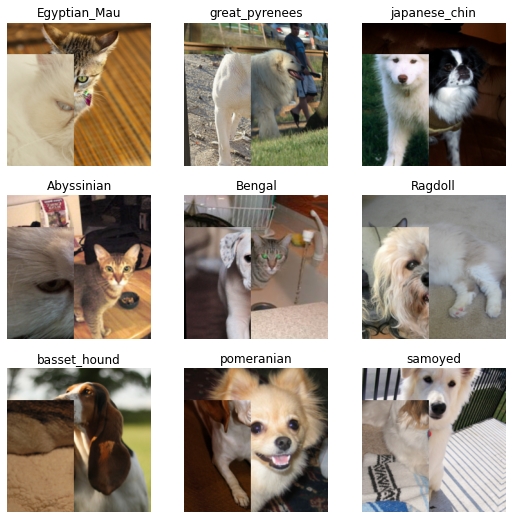

In [ ]:
cutmix = CutMix(1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())

We train with it in the exact same way as well

In [ ]:
#slow
learn = cnn_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, error_rate])
learn.fit_one_cycle(1, cbs=cutmix)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.440883,0.793059,0.769959,0.230041,00:12


# Export - 

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 01a_losses.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 10b_tutorial.albumentations.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 18a_callback.training.ipynb.
Converted 18b_callback.preds.ipynb.
Converted 